<a href="https://colab.research.google.com/github/garfield-gray/Optimization/blob/main/Convex/IntProg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The class

In [9]:
import numpy as np

In [ ]:
# you may wanna do more tests
# you could manuplate the pivot, standardize , ... to make it more memory efficient!
# could be refactored! maybe!!

In [68]:
import numpy as np

class IntProg:
    def __init__(self, c, A, b):
        self.c = c
        self.A = A
        self.b = b
        self.n = len(c)
        self.m = len(b)
        self.tableau = np.zeros((self.m + 1, self.n + 2))
        self.basic_variables = np.zeros_like(b)
        self.solution = np.zeros_like(b)
        self.verbose = False
        self.answer = None
        self.message = None
        self.error = None

    def solve(self, intify = True, verbose = False):
        self.verbose = verbose
        if intify:
            self.tableau = self.__integer_simplex()
        else:
            self.tableau = self.__simplex()
        self.solution = self.tableau[1:self.m+1, -1]
        self.basic_variables = self.tableau[1:, 0]
        self.answer = self.tableau[0, -1]


    def __pivot(self, tableau, row, col):
        """ Pivots """
        basics = tableau[1:, 0].copy()
        tableau = tableau.astype(float)

        pivot_element = tableau[row, col]
        tableau[row] /= pivot_element
        for i in range(tableau.shape[0]):
            if i != row:
                tableau[i] -= tableau[i, col] * tableau[row]
                tableau[i, 0] = tableau[row, 0]
        basics[row-1] = col-1
        tableau[1:, 0] = basics
        tableau[0, 0] = 1
        return tableau

    def __standardize(self, tableau):
        """ __standardize (the basic variables must have 0 coeficient in the 0th row huh?) """
        m, n = tableau.shape
        m -= 1
        n -= 2

        for i in range(m):
            tableau[0] -= tableau[0, int(tableau[i+1, 0] + 1)] * tableau[i+1]

        tableau[0, 0] = 1
        return tableau


    def __core_simplex(self, tableau):
        """ Core Simplex: findes what to pivot and does it:) """
        basics = tableau[1:, 0].copy()
        m, n = tableau.shape
        m -= 1
        n -= 2

        while True:
            if np.all(tableau[0, 1:-1] <= 0):
                break
            pivot_col = np.argmax(tableau[0, 1:-1]) + 1
            ratios = np.divide(tableau[1:, -1], tableau[1:, pivot_col])

            valid_ratios = ratios[tableau[1:, pivot_col] > 0]
            if len(valid_ratios) == 0:
                raise ValueError("The problem is unbounded.")
            pivot_row = np.where(ratios == valid_ratios.min())[0][0] + 1
            tableau = self.__pivot(tableau, pivot_row, pivot_col)
            basics = tableau[1:, 0]

        tableau[1:, 0] = basics
        tableau[0, 0] = 1
        return tableau

    def __phase1(self, tableau):
        """
        Takes the tableau with no feasible solution and outputs with BFS (not standardized).
        """
        # Copy basic variables from the tableau
        basics = tableau[1:, 0].copy()

        # Determine the dimensions of the tableau
        m, n = tableau.shape
        m -= 1  # Number of constraints
        n -= 2  # Number of variables

        # Extract the right-hand side (b vector)
        b = tableau[1:, -1]

        # Create the transformation matrix P
        p = np.eye(m + 1)
        p[np.where(b < 0) + np.ones_like(np.where(b < 0))] *= -1

        # Transform the tableau using P
        Rtableau = p @ tableau

        # Insert additional columns for artificial variables and constraints
        Rtableau = np.insert(Rtableau, -1, np.vstack((-np.ones(m), np.eye(m))).T, axis=1)
        Rtableau[0, 0] = 1
        Rtableau[0, -1] = 0

        # Fix the basic variables and adjust the objective row
        Rtableau[1:, 0] = np.arange(n, n + m)
        Rtableau[0, 1:n + 1] = np.zeros(n)

        # __standardize the tableau
        Rtableau = self.__standardize(Rtableau)

        # Perform the core simplex algorithm
        Rtableau = self.__core_simplex(Rtableau)

        # Check if the problem is unbounded
        if not np.isclose(Rtableau[0, -1], 0):
            raise ValueError("The problem is unbounded.")

        # Check if all variables in the base aren't artificial
        if np.all(Rtableau[1:, 0] < n):
            return np.delete(Rtableau, np.s_[n + 1:n + m + 1], axis=1)

        # exception 1 (in case the the problem is feasible but the artificial variables are still in the base)
        # Artificials in the base:
        RinBs = np.where(Rtableau[1:, 0] >= n)[0]+1
        for i in RinBs:
            # cc is the column to be pivoted
            cc = np.where(~np.isclose(Rtableau[i, 1:-1], 0))[0][0]
            # it would be exception 2 (haven't been tested)
            if cc >=n :
                Rtableau = np.delete(Rtableau, np.s_[i], axis=0)
            Rtableau = Pivot(Rtableau, i, cc+1)
            # print(np.round(Rtableau, 2))


        return np.delete(Rtableau, np.s_[n + 1:n + m + 1], axis=1)


    def __simplex(self):

        # creation of bfs (Basic feasible solution through Artificial variables)

        self.tableau[1:, 1:-1] = self.A
        self.tableau[1:, -1] = self.b
        self.tableau = self.__phase1(self.tableau)
        self.tableau[0, 1:-1] = -self.c
        self.tableau = self.__standardize(self.tableau)
        self.tableau = self.__core_simplex(self.tableau)

        return self.tableau

    def __integer_simplex(self):
        n = self.n
        m = self.m
        # Initialize the simplex tableau
        # (this tableu gets augmented over time and is different with the original tableau )
        self.tableau = self.__simplex()
        while True:
            # Check if we have an optimal solution (all entries in the objective row are negative)
            if np.allclose(np.round(self.tableau[1:, -1]), self.tableau[1:, -1], atol=1e-6):
                break

            # Find the index of the first fractional variable in the solution
            frac_index = (np.where(np.modf(self.tableau[1:, -1])[0] != 0)[0] + 1)[0]
            gomory_cut = -(self.tableau[frac_index] - np.floor(self.tableau[frac_index]))

            # Apply the Gomory cut
            if self.verbose:
                print(f"Applying Gomory cut: {np.round(gomory_cut, 2)}")
            self.tableau = np.vstack((self.tableau, gomory_cut))

            # Add a new variable to the tableau
            newVar = np.zeros(self.tableau.shape[0])
            newVar[-1] = 1
            self.tableau = np.insert(self.tableau, -1, newVar, axis=1)


            # Print the updated tableau
            if self.verbose:
                print(np.round(self.tableau, 2))

            # Perform phase 1 of the simplex method
            self.tableau = self.__phase1(self.tableau)

            # Reset the objective row
            self.tableau[0] = 0
            self.tableau[0, 1:1 + n] = -c

            # __standardize the tableau
            self.tableau = self.__standardize(self.tableau)

            # Perform the core simplex algorithm
            self.tableau = self.__core_simplex(self.tableau)

        return self.tableau

    def print_tableau(self):
        pass

In [71]:
A = np.array([
    [3, 1,-1, 0],
    [1, 2, 0,-1],

])
b = np.array([4, 4])
c = np.array([3, 4, 0, 0])

sample = IntProg(c, A, b)
sample.solve(verbose=True)

Applying Gomory cut: [-0.  -0.  -0.  -0.6 -0.2 -0.8]
[[ 1.   0.   0.  -0.4 -1.8  0.   8.8]
 [ 0.   1.   0.  -0.4  0.2  0.   0.8]
 [ 1.   0.   1.   0.2 -0.6  0.   1.6]
 [-0.  -0.  -0.  -0.6 -0.2  1.  -0.8]]
Applying Gomory cut: [-0.   -0.   -0.   -0.   -0.33 -0.33 -0.33]
[[ 1.    0.    0.    0.   -1.67 -0.67  0.    9.33]
 [ 0.    1.    0.    0.    0.33 -0.67  0.    1.33]
 [ 1.    0.    1.    0.   -0.67  0.33  0.    1.33]
 [ 2.    0.    0.    1.    0.33 -1.67  0.    1.33]
 [-0.   -0.   -0.   -0.   -0.33 -0.33  1.   -0.33]]


<ipython-input-68-8d309c82e42a>:69: RuntimeWarning: divide by zero encountered in divide
  ratios = np.divide(tableau[1:, -1], tableau[1:, pivot_col])


In [70]:
sample.solution

array([2., 1.])

# Requirements

In [14]:
from scipy.optimize import LinearConstraint, milp
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt


In [15]:
# # Pivot
# """
#     Perform pivot operation on the tableau at the specified row and column.

#     Parameters:
#     tableau (ndarray): The current tableau.
#     row (int): The row index of the pivot element.
#     col (int): The column index of the pivot element.

#     Returns:
#     ndarray: The updated tableau after pivoting.
#     """
# # Standardize
# """
#     Standardize the tableau to prepare it for the simplex algorithm.

#     Parameters:
#     tableau (ndarray): The current tableau.

#     Returns:
#     ndarray: The standardized tableau.
#     """
# # CoreSimplex
#   """
#     Execute the core simplex algorithm on the tableau.

#     Parameters:
#     tableau (ndarray): The standardized tableau with a basic feasible solution.

#     Returns:
#     ndarray: The tableau after performing the simplex algorithm.
#     """

# # phase 1 (handle the exceptions!!)
# """
#     Perform Phase 1 of the simplex method to find a basic feasible solution.

#     Parameters:
#     tableau (ndarray): The initial tableau without a feasible solution.

#     Returns:
#     ndarray: The tableau with a basic feasible solution.
#     """

# # simplex
#  """
#     Perform the simplex algorithm on the given linear programming problem.

#     Parameters:
#     c (ndarray): The coefficients of the objective function.
#     A (ndarray): The constraint coefficients.
#     b (ndarray): The right-hand side values of the constraints.

#     Returns:
#     ndarray: The final tableau after performing the simplex algorithm.
#     """
# # integer_simplex

# Integer Programming
Checking the integer solution using scipy intprog module

In [16]:
c = np.array([3, 4])
A = np.array([[-3, -1], [-1, -2]])
b_u = np.array([-4, -4])
b_l = np.full_like(b_u, -np.inf, dtype=float)
# b_l = np.full_like(b_u, 0, dtype=float)

In [17]:
constraints = LinearConstraint(A, b_l, b_u)

In [18]:
integrality = np.ones_like(c)
res = milp(c=c, constraints=constraints, integrality=integrality)
res.x

array([2., 1.])

In [19]:
res = milp(c=c, constraints=constraints)  # OR:
# from scipy.optimize import linprog; res = linprog(c, A, b_u)
res.x

array([0.8, 1.6])

# Linear Programming
Checking the optimal solution using scipy linprog module

In [20]:
c = [3, 4]
A = [[-3, -1], [-1, -2]]
b = [-4, -4]
x0_bounds = (0, None)
x1_bounds = (0, None)
res = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds])
res.fun


8.8

In [21]:
res.x

array([0.8, 1.6])

In [22]:
res.message

'Optimization terminated successfully. (HiGHS Status 7: Optimal)'

# Cutting Plane Algorithm

In [23]:
def Pivot(tableau, row, col):
    basics = tableau[1:, 0].copy()
    tableau = tableau.astype(float)

    pivot_element = tableau[row, col]
    tableau[row] /= pivot_element
    for i in range(tableau.shape[0]):
        if i != row:
            tableau[i] -= tableau[i, col] * tableau[row]
            tableau[i, 0] = tableau[row, 0]
    basics[row-1] = col-1
    tableau[1:, 0] = basics
    tableau[0, 0] = 1
    return tableau


Example for test

In [24]:
t = np.array([
    [ 1, -1,  4,  0,  0,  6, -1, -1, -1,  0],
    [ 5,  1, -1, -1,  0,  4,  1,  0,  0,  1],
    [ 6, -1,  4,  0,  1,  0,  0,  1,  0,  7],
    [ 7,  3,  1,  0,  0,  1,  0,  0,  1, 18]
])
np.round(Pivot(t, 1, 1),1)

array([[  1.,   0.,   3.,  -1.,   0.,  10.,   0.,  -1.,  -1.,   1.],
       [  0.,   1.,  -1.,  -1.,   0.,   4.,   1.,   0.,   0.,   1.],
       [  6.,   0.,   3.,  -1.,   1.,   4.,   1.,   1.,   0.,   8.],
       [  7.,   0.,   4.,   3.,   0., -11.,  -3.,   0.,   1.,  15.]])

In [25]:

def Standardize(tableau):
    m, n = tableau.shape
    m -= 1
    n -= 2

    for i in range(m):
        tableau[0] -= tableau[0, int(tableau[i+1, 0] + 1)] * tableau[i+1]

    tableau[0, 0] = 1
    return tableau

t = np.array([[ 1, -1,  4,  0,  0,  0, -1, -1, -1,  0],
              [ 5,  1, -1, -1,  0,  0,  1,  0,  0,  1],
              [ 6, -1,  4,  0,  1,  0,  0,  1,  0,  7],
              [ 7,  3,  1,  0,  0,  1,  0,  0,  1, 18]])
Standardize(t)

array([[ 1,  2,  8, -1,  1,  1,  0,  0,  0, 26],
       [ 5,  1, -1, -1,  0,  0,  1,  0,  0,  1],
       [ 6, -1,  4,  0,  1,  0,  0,  1,  0,  7],
       [ 7,  3,  1,  0,  0,  1,  0,  0,  1, 18]])

Example for test

In [26]:
t = np.array([[ 1, -1,  4,  0,  0,  0, -1, -1, -1,  0],
              [ 5,  1, -1, -1,  0,  0,  1,  0,  0,  1],
              [ 6, -1,  4,  0,  1,  0,  0,  1,  0,  7],
              [ 7,  3,  1,  0,  0,  1,  0,  0,  1, 18]])
Standardize(t)

array([[ 1,  2,  8, -1,  1,  1,  0,  0,  0, 26],
       [ 5,  1, -1, -1,  0,  0,  1,  0,  0,  1],
       [ 6, -1,  4,  0,  1,  0,  0,  1,  0,  7],
       [ 7,  3,  1,  0,  0,  1,  0,  0,  1, 18]])

In [27]:
def CoreSimplex(tableau):
    basics = tableau[1:, 0].copy()
    m, n = tableau.shape
    m -= 1
    n -= 2
    while True:
        if np.all(tableau[0, 1:-1] <= 0):
            break
        pivot_col = np.argmax(tableau[0, 1:-1]) + 1
        ratios = np.divide(tableau[1:, -1], tableau[1:, pivot_col])
        valid_ratios = ratios[tableau[1:, pivot_col] > 0]
        if len(valid_ratios) == 0:
            raise ValueError("The problem is unbounded.")
        pivot_row = np.where(ratios == valid_ratios.min())[0][0] + 1
        tableau = Pivot(tableau, pivot_row, pivot_col)
        basics = tableau[1:, 0]

    tableau[1:, 0] = basics
    tableau[0, 0] = 1
    return tableau


Example for test

In [28]:
t = np.array(
    [[ 1, -1,  4,  0,  0,  0,  0],
     [ 2, -1,  1,  1,  0,  0,  1],
     [ 3, -1,  4,  0,  1,  0,  7],
     [ 4,  3,  1,  0,  0,  1, 18]])
print(np.round(CoreSimplex(t), 4))

[[ 1.      0.      0.      0.     -1.      0.     -7.    ]
 [ 1.      0.      1.     -0.3333  0.3333  0.      2.    ]
 [ 0.      1.      0.     -1.3333  0.3333  0.      1.    ]
 [ 4.      0.      0.      4.3333 -1.3333  1.     13.    ]]


In [29]:
def Phase1(tableau):
    """
    Takes the tableau with no feasible solution and outputs with BFS (not standardized).
    """
    # Copy basic variables from the tableau
    basics = tableau[1:, 0].copy()

    # Determine the dimensions of the tableau
    m, n = tableau.shape
    m -= 1  # Number of constraints
    n -= 2  # Number of variables

    # Extract the right-hand side (b vector)
    b = tableau[1:, -1]

    # Create the transformation matrix P
    p = np.eye(m + 1)
    p[np.where(b < 0) + np.ones_like(np.where(b < 0))] *= -1

    # Transform the tableau using P
    Rtableau = p @ tableau

    # Insert additional columns for artificial variables and constraints
    Rtableau = np.insert(Rtableau, -1, np.vstack((-np.ones(m), np.eye(m))).T, axis=1)
    Rtableau[0, 0] = 1
    Rtableau[0, -1] = 0

    # Fix the basic variables and adjust the objective row
    Rtableau[1:, 0] = np.arange(n, n + m)
    Rtableau[0, 1:n + 1] = np.zeros(n)

    # Standardize the tableau
    Rtableau = Standardize(Rtableau)

    # Perform the core simplex algorithm
    Rtableau = CoreSimplex(Rtableau)

    # Check if the problem is unbounded
    if not np.isclose(Rtableau[0, -1], 0):
        raise ValueError("The problem is unbounded.")

    # Check if all variables in the base aren't artificial
    if np.all(Rtableau[1:, 0] < n):
        return np.delete(Rtableau, np.s_[n + 1:n + m + 1], axis=1)

    # exception 1 (in case the the problem is feasible but the artificial variables are still in the base)
    # Artificials in the base:
    RinBs = np.where(Rtableau[1:, 0] >= n)[0]+1
    for i in RinBs:
        # cc is the column to be pivoted
        cc = np.where(~np.isclose(Rtableau[i, 1:-1], 0))[0][0]
        # it would be exception 2 (haven't been tested)
        if cc >=n :
            Rtableau = np.delete(Rtableau, np.s_[i], axis=0)
        Rtableau = Pivot(Rtableau, i, cc+1)
    # print(np.round(Rtableau, 2))


    return np.delete(Rtableau, np.s_[n + 1:n + m + 1], axis=1)



Example for test(the exception1)

In [30]:
t = np.array([
    [ 1, 2, 1, 0, 0, 0],
    [ 0, 1, 0,-1, 0, 1],
    [ 0, 2, 1, 1, 0, 2],
    [ 0, 1,-1,-2,-1, 1]
])
np.round(Phase1(t), 4)

array([[ 1. ,  0. ,  0. ,  0. , -0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. , -0.5,  1. ],
       [ 2. ,  0. ,  0. ,  1. , -0.5,  0. ],
       [ 1. , -0. ,  1. , -0. ,  1.5, -0. ]])

Example for test

In [31]:
t = np.array(
    [[ 1,  1,  1,  1,  0,  0],
     [ 1,  1, -1,  3,  0,  1],
     [ 1,  1,  1,  0, -1,  2],
     [ 1,  1,  0, -1,  0,  1]])
np.round(Phase1(t), 4)

array([[ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. , -0.2,  1.2],
       [ 2. ,  0. ,  0. ,  1. , -0.2,  0.2],
       [ 1. ,  0. ,  1. ,  0. , -0.8,  0.8]])

In [32]:
def simplex(c, A, b):
    # Number of variables
    n = len(c)

    # Number of constraints
    m = len(b)

    # creation of bfs (Basic feasible solution through Artificial variables)
    tableau = np.zeros((m + 1, n + 2))
    tableau[1:, 1:-1] = A
    tableau[1:, -1] = b
    tableau = Phase1(tableau)
    tableau[0, 1:-1] = -c
    tableau = Standardize(tableau)
    tableau = CoreSimplex(tableau)

    return tableau

def print_tableau(tableau, headers):
    print("Tableau:")
    print(" | ".join(headers))
    print("-" * (len(headers) * 8))
    for row in tableau:
        print(" | ".join(f"{x:>7.2f}" for x in row))
    print()



Example **usage**

In [33]:
A = np.array([
    [3, 1, -1, 0],
    [1, 2, 0, -1],
])
b = np.array([4, 4])
c = np.array([3, 4, 0, 0])

headers = ["Basic"] + [f"x{i+1}" for i in range(len(c))] + ["RHS"]

print("Simplex Solution:")
solution = np.round(simplex(c, A, b), 4)
print_tableau(solution, headers)

Simplex Solution:
Tableau:
Basic | x1 | x2 | x3 | x4 | RHS
------------------------------------------------
   1.00 |    0.00 |    0.00 |   -0.40 |   -1.80 |    8.80
   0.00 |    1.00 |    0.00 |   -0.40 |    0.20 |    0.80
   1.00 |    0.00 |    1.00 |    0.20 |   -0.60 |    1.60



In [34]:
def integer_simplex(c, A, b):
    # Determine the number of variables and constraints
    n = len(c)
    m = len(b)

    # Initialize the simplex tableau
    tableau = simplex(c, A, b)

    while True:
        # Check if we have an optimal solution (all entries in the objective row are negative)
        if np.allclose(np.round(tableau[1:, -1]), tableau[1:, -1], atol=1e-6):
            break

        # Find the index of the first fractional variable in the solution
        frac_index = (np.where(np.modf(tableau[1:, -1])[0] != 0)[0] + 1)[0]
        gomory_cut = -(tableau[frac_index] - np.floor(tableau[frac_index]))

        # Apply the Gomory cut
        print(f"Applying Gomory cut: {gomory_cut}")
        tableau = np.vstack((tableau, gomory_cut))

        # Add a new variable to the tableau
        newVar = np.zeros(tableau.shape[0])
        newVar[-1] = 1
        tableau = np.insert(tableau, -1, newVar, axis=1)

        # Print the updated tableau
        print(np.round(tableau, 2))

        # Perform phase 1 of the simplex method
        tableau = Phase1(tableau)

        # Reset the objective row
        tableau[0] = 0
        tableau[0, 1:1 + n] = -c

        # Standardize the tableau
        tableau = Standardize(tableau)

        # Perform the core simplex algorithm
        tableau = CoreSimplex(tableau)

    return tableau


Example **usage 1** (from Bazaraa)

In [35]:
A = np.array([
    [3, 1,-1, 0],
    [1, 2, 0,-1],

])
b = np.array([4, 4])
c = np.array([3, 4, 0, 0])

# Round the result to 4 decimal places
result = integer_simplex(c, A, b)

print("Integer Simplex Solution:")
print(np.round(result, 4))

Applying Gomory cut: [-0.  -0.  -0.  -0.6 -0.2 -0.8]
[[ 1.   0.   0.  -0.4 -1.8  0.   8.8]
 [ 0.   1.   0.  -0.4  0.2  0.   0.8]
 [ 1.   0.   1.   0.2 -0.6  0.   1.6]
 [-0.  -0.  -0.  -0.6 -0.2  1.  -0.8]]
Applying Gomory cut: [-0.         -0.         -0.         -0.         -0.33333333 -0.33333333
 -0.33333333]
[[ 1.    0.    0.    0.   -1.67 -0.67  0.    9.33]
 [ 0.    1.    0.    0.    0.33 -0.67  0.    1.33]
 [ 1.    0.    1.    0.   -0.67  0.33  0.    1.33]
 [ 2.    0.    0.    1.    0.33 -1.67  0.    1.33]
 [-0.   -0.   -0.   -0.   -0.33 -0.33  1.   -0.33]]
Integer Simplex Solution:
[[ 1.  0.  0.  0. -1.  0. -2. 10.]
 [ 0.  1.  0.  0.  1.  0. -2.  2.]
 [ 1.  0.  1.  0. -1.  0.  1.  1.]
 [ 2.  0.  0.  1.  2.  0. -5.  3.]
 [ 4.  0.  0.  0.  1.  1. -3.  1.]]


<ipython-input-27-c1886c0eefb4>:10: RuntimeWarning: divide by zero encountered in divide
  ratios = np.divide(tableau[1:, -1], tableau[1:, pivot_col])


Example **usage 2** (from Rao)

In [36]:
A = np.array([
    [3, -1, 1, 0],
    [3, 11, 0, 1]
])
b = np.array([12, 66])
c = np.array([-3, -4, 0, 0])

# Round the result to 4 decimal places
result = integer_simplex(c, A, b)
print("Integer Simplex Solution:")
print(np.round(result, 4))

Applying Gomory cut: [-0.         -0.         -0.         -0.30555556 -0.02777778 -0.5       ]
[[ 1.00e+00  0.00e+00  0.00e+00 -5.80e-01 -4.20e-01  0.00e+00 -3.45e+01]
 [ 0.00e+00  1.00e+00  0.00e+00  3.10e-01  3.00e-02  0.00e+00  5.50e+00]
 [ 1.00e+00  0.00e+00  1.00e+00 -8.00e-02  8.00e-02  0.00e+00  4.50e+00]
 [-0.00e+00 -0.00e+00 -0.00e+00 -3.10e-01 -3.00e-02  1.00e+00 -5.00e-01]]
Applying Gomory cut: [-0.         -0.         -0.         -0.         -0.09090909 -0.72727273
 -0.63636364]
[[  1.     0.     0.     0.    -0.36  -1.91   0.   -33.55]
 [  0.     1.     0.     0.     0.     1.     0.     5.  ]
 [  1.     0.     1.     0.     0.09  -0.27   0.     4.64]
 [  2.     0.     0.     1.     0.09  -3.27   0.     1.64]
 [ -0.    -0.    -0.    -0.    -0.09  -0.73   1.    -0.64]]
Applying Gomory cut: [-0.    -0.    -0.    -0.    -0.875 -0.    -0.375 -0.125]
[[  1.     0.     0.     0.    -0.12   0.    -2.62   0.   -31.88]
 [  0.     1.     0.     0.    -0.12   0.     1.38   0.     4.1

<ipython-input-27-c1886c0eefb4>:10: RuntimeWarning: divide by zero encountered in divide
  ratios = np.divide(tableau[1:, -1], tableau[1:, pivot_col])


In [37]:
def plot_feasible_set_and_cuts(c, A, b, solutions):
    # Determine the number of original variables (non-slack variables)
    num_original_vars = len(c) - np.sum(c == 0)
    if num_original_vars != 2:
        raise ValueError("This function only supports 2-variable problems for plotting.")

    fig, ax = plt.subplots()

    # Generate a grid for plotting
    x = np.linspace(-1, 20, 400)
    y = np.linspace(-1, 20, 400)
    X, Y = np.meshgrid(x, y)

    # Plot the feasible region
    for i in range(A.shape[0]):
        plt.contourf(X, Y, A[i, 0] * X + A[i, 1] * Y - b[i], levels=[0, 1e6], alpha=0.5, colors=['lightblue'])

    # Plot integer points
    x_int = np.arange(-1, 21, 1)
    y_int = np.arange(-1, 21, 1)
    X_int, Y_int = np.meshgrid(x_int, y_int)
    int_points = np.c_[X_int.ravel(), Y_int.ravel()]

    feasible_int_points = []
    for point in int_points:
        if np.all(np.dot(A[:, :2], point) >= b):
            feasible_int_points.append(point)

    feasible_int_points = np.array(feasible_int_points)
    plt.scatter(feasible_int_points[:, 0], feasible_int_points[:, 1], color='grey', marker='.', label='Integer Points')

    # Labels and legend
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Feasible Set and Gomory Cuts')
    plt.legend()
    plt.xlim(-1, 10)
    plt.ylim(-1, 10)

    # Plot the cuts
    plot_cuts(ax, solutions)

    plt.show()

def plot_cuts(ax, cuts):
    x = np.linspace(-1, 20, 400)
    for idx, cut in enumerate(cuts):
        A_cut, b_cut = cut[:-1], cut[-1]
        if A_cut[1] != 0:  # Avoid division by zero
            y = (b_cut - A_cut[0] * x) / A_cut[1]
            ax.plot(x, y, label=f'Gomory Cut {idx + 1}: {A_cut[0]}*x1 + {A_cut[1]}*x2 = {b_cut}', linestyle='-', linewidth=0.5, color="red")
            # Add annotation for clarity
            ax.annotate(f'Cut {idx + 1}', xy=(x[200], y[200]), xytext=(x[200] + 1, y[200] + 1),
                        arrowprops=dict(facecolor='black', shrink=0.0005))

    # Move legend outside the plot
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

    # Calculate Gomory cuts
    tableau = simplex(c, A, b)
    frac_index = (np.where(np.modf(tableau[1:, -1])[0] != 0)[0] + 1)[0]
    gomory_cut = -(tableau[frac_index] - np.floor(tableau[frac_index]))

    return [gomory_cut]



Applying Gomory cut: [-0.  -0.  -0.  -0.6 -0.2 -0.8]
[[ 1.   0.   0.  -0.4 -1.8  0.   8.8]
 [ 0.   1.   0.  -0.4  0.2  0.   0.8]
 [ 1.   0.   1.   0.2 -0.6  0.   1.6]
 [-0.  -0.  -0.  -0.6 -0.2  1.  -0.8]]
Applying Gomory cut: [-0.         -0.         -0.         -0.         -0.33333333 -0.33333333
 -0.33333333]
[[ 1.    0.    0.    0.   -1.67 -0.67  0.    9.33]
 [ 0.    1.    0.    0.    0.33 -0.67  0.    1.33]
 [ 1.    0.    1.    0.   -0.67  0.33  0.    1.33]
 [ 2.    0.    0.    1.    0.33 -1.67  0.    1.33]
 [-0.   -0.   -0.   -0.   -0.33 -0.33  1.   -0.33]]
Integer Simplex Solution:
[[ 1.  0.  0.  0. -1.  0. -2. 10.]
 [ 0.  1.  0.  0.  1.  0. -2.  2.]
 [ 1.  0.  1.  0. -1.  0.  1.  1.]
 [ 2.  0.  0.  1.  2.  0. -5.  3.]
 [ 4.  0.  0.  0.  1.  1. -3.  1.]]


<ipython-input-27-c1886c0eefb4>:10: RuntimeWarning: divide by zero encountered in divide
  ratios = np.divide(tableau[1:, -1], tableau[1:, pivot_col])


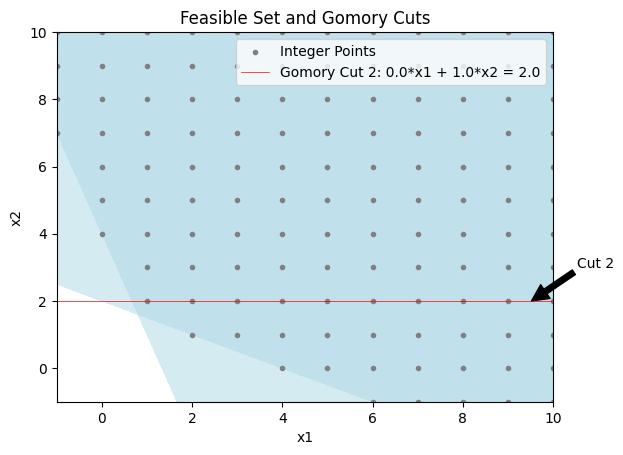

In [38]:
A = np.array([
    [3, 1,-1, 0],
    [1, 2, 0,-1],

])
b = np.array([4, 4])
c = np.array([3, 4, 0, 0])

# Round the result to 4 decimal places
result = np.round(integer_simplex(c, A, b), 4)

print("Integer Simplex Solution:")
print(np.round(result, 4))

plot_feasible_set_and_cuts(c, A, b, result)


# Latexify

In [40]:
@latexify.function
def solve(a, b, c):
  return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

print(solve(1, 4, 3))  # Invoking the function works as expected.
print(solve)  # Printing the function shows the underlying LaTeX source.
solve  # Displays the expression.

# Writes the underlying LaTeX source into a file.
with open("compiled.tex", "w") as fp:
  print(solve, file=fp)


NameError: name 'latexify' is not defined

In [42]:
@latexify.expression
def solve(a, b, c):
  return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

print(solve(1, 4, 3))  # Invoking the function works as expected.
print(solve)  # Printing the function shows the underlying LaTeX source.
solve  # Displays the expression.

# Writes the underlying LaTeX source into a file.
with open("compiled.tex", "w") as fp:
  print(solve, file=fp)


NameError: name 'latexify' is not defined

In [44]:
@latexify.algorithmic
def fib(x):
  if x == 0:
    return 0
  elif x == 1:
    return 1
  else:
    return fib(x-1) + fib(x-2)

fib

NameError: name 'latexify' is not defined

In [54]:
@latexify.expression
def Pivot(tableau, row, col):
    basics = tableau[1:, 0].copy()
    tableau = tableau.astype(float)

    pivot_element = tableau[row, col]
    tableau[row] /= pivot_element
    for i in range(tableau.shape[0]):
        if i != row:
            tableau[i] -= tableau[i, col] * tableau[row]
            tableau[i, 0] = tableau[row, 0]
    basics[row-1] = col-1
    tableau[1:, 0] = basics
    tableau[0, 0] = 1
    return tableau
Pivot

NameError: name 'latexify' is not defined

In [55]:
# Assignments can be reduced into one expression.
@latexify.function(reduce_assignments=True)
def f(a, b, c):
    discriminant = b**2 - 4 * a * c
    numerator = -b + math.sqrt(discriminant)
    denominator = 2 * a
    return numerator / denominator

f


NameError: name 'latexify' is not defined

# more tests

In [72]:
c = np.array([7, 4])
A = np.array([[-3, -1], [-1, -2]])
b_u = np.array([-4, -2])
b_l = np.full_like(b_u, -np.inf, dtype=float)
# b_l = np.full_like(b_u, 0, dtype=float)
constraints = LinearConstraint(A, b_l, b_u)
integrality = np.ones_like(c)
res = milp(c=c, constraints=constraints, integrality=integrality)
res.x

array([1., 1.])

In [ ]:
A = np.array([
    [3, 1,-1, 0],
    [1, 2, 0,-1],

])
b = np.array([4, 2])
c = np.array([7, 4, 0, 0])

# Round the result to 4 decimal places
result = integer_simplex(c, A, b)

result[:,[0,-1]]

In [ ]:
2